<a href="https://colab.research.google.com/github/PiotrMaciejKowalski/BigData2024Project/blob/Analiza-szeregow-czasowych-dot-roslinnosci/colabs/Analiza_szeregow_czasowych_dot_roslinnosci.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wczytywanie danych w sparku

Utworzenie środowiska pyspark do obliczeń:

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz
!pip install -q findspark

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

In [4]:
import findspark
findspark.init()

In [5]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from google.colab import drive
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame as SparkDataFrame
from pyspark.sql.types import IntegerType, FloatType, StringType, StructType

Utowrzenie sesji:

In [6]:
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

Połączenie z dyskiem:

In [8]:
drive.mount('/content/drive')

Mounted at /content/drive


Wczytanie danych NASA znajdujących się na dysku w sparku:

In [9]:
columns = ['lon', 'lat', 'Date', 'SWdown', 'LWdown', 'SWnet', 'LWnet', 'Qle', 'Qh', 'Qg', 'Qf', 'Snowf', 'Rainf', 'Evap', 'Qs', 'Qsb', 'Qsm', 'AvgSurfT', 'Albedo', 'SWE', 'SnowDepth', 'SnowFrac', 'SoilT_0_10cm', 'SoilT_10_40cm',
           'SoilT_40_100cm', 'SoilT_100_200cm', 'SoilM_0_10cm', 'SoilM_10_40cm', 'SoilM_40_100cm', 'SoilM_100_200cm', 'SoilM_0_100cm', 'SoilM_0_200cm', 'RootMoist', 'SMLiq_0_10cm', 'SMLiq_10_40cm', 'SMLiq_40_100cm', 'SMLiq_100_200cm',
           'SMAvail_0_100cm', 'SMAvail_0_200cm', 'PotEvap', 'ECanop', 'TVeg', 'ESoil', 'SubSnow', 'CanopInt', 'ACond', 'CCond', 'RCS', 'RCT', 'RCQ', 'RCSOL', 'RSmin','RSMacr', 'LAI', 'GVEG', 'Streamflow']

# Utworzenie schematu określającego typ zmiennych
schema = StructType()
for i in columns:
  if i == "Date":
    schema = schema.add(i, StringType(), True)
  else:
    schema = schema.add(i, FloatType(), True)

In [10]:
# Wczytanie zbioru Nasa w sparku
nasa = spark.read.format('csv').option("header", True).schema(schema).load('/content/drive/MyDrive/BigMess/NASA/NASA.csv')

Zanim zaczniemy pisać kwerendy należy jeszcze dodać nasz DataFrame (df) do "przestrzeni nazw tabel" Sparka:

In [11]:
nasa.createOrReplaceTempView("nasa")

Rozdzielenie kolumny "Date" na kolumny "Year" oraz "Month"

In [12]:
nasa_ym = spark.sql("""
          SELECT
          CAST(SUBSTRING(CAST(Date AS STRING), 1, 4) AS INT) AS Year,
          CAST(SUBSTRING(CAST(Date AS STRING), 5, 2) AS INT) AS Month,
          n.*
          FROM nasa n
          """)

In [13]:
nasa_ym = nasa_ym.drop("Date")
nasa_ym.createOrReplaceTempView("nasa_ym")

# Analiza szergów czasowych  dot. roślinności

In [14]:
# Ograniczenie zbioru nasa do wartości, które potrzebujemy, ustawienie pomiaru zawsze na 1 dzień miesiąca
GVEG_SparkDataFrame = spark.sql("""
                        SELECT
                        lon, lat,
                        to_date(CONCAT(Year, '-', Month, '-1')) as Date, GVEG
                        FROM nasa_ym
                        order by lon, lat, Year, Month
                        """)

In [15]:
# Wyzanczenie unikatowych par współrzednych ze zbioru Nasa i zapisanie w Pandas
%%time
distinct_wsp = spark.sql("""
                          SELECT DISTINCT lon, lat FROM nasa
                          """).toPandas()

CPU times: user 1.38 s, sys: 139 ms, total: 1.52 s
Wall time: 3min 52s


In [17]:
distinct_wsp.shape

(76360, 2)

In [18]:
# FIXME przenieść do katalogu src / @see (https://app.clickup.com/t/86bwj0nt4)
def extract_time_series_from_dataframe(sdf: SparkDataFrame, lon: float, lat: float) -> pd.DataFrame:
  """
  Funkcja przekształcająca zadany SparkDataFrame w szereg czasowy dla zadanych współrzednych lon, lat.
  Parametry:
  - df (SparkDataFrame): ramka danych w Sparku zawierająca następujace kolumny: lon, lat, Date (pomiar ustawiony na pierwszy dzien miesiąca), atrybuty
  - lon (float): długość geograficzna
  - lat (float): szerokość geograficzna
  """
  # ograniczenie zbioru do konkretnej pary współrzędnych
  time_series = sdf.filter((sdf['lon'] == lon) & (sdf['lat'] == lat))
  # Przejście na pandas
  time_series_Pandas = time_series.toPandas()
  # Ustawienie 'date' jako indeksu
  time_series_Pandas.set_index('Date', inplace=True)
  return time_series_Pandas

In [24]:
# Test
GVEG_time_series = extract_time_series_from_dataframe(GVEG_SparkDataFrame, -89.4375, 32.1875)

In [25]:
# FIXME przenieść do katalogu src / @see (https://app.clickup.com/t/86bwj0nt4)
def plot_time_series(df: pd.DataFrame, attribute: str) -> None:
  """
  Funkcja generująca wykres w czasie dla zadanego atrybutu.
  Parametry:
  - df (DataFrame): szereg czasowy; Pandas DataFrame
  - attribute (str): atrybut, dla którego chcemy zrobić wykres w czasie
  """
  assert attribute in df.columns, f"The attribute '{attribute}' is not a column in the DataFrame."
  # Obliczanie 12-miesięcznej średniej kroczącej
  df['12m_MA'] = df[attribute].rolling(window=12).mean()
  # Tworzenie wykresu
  plt.figure(figsize=(11,6))
  gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
  xmin, xmax = df.index.min() - pd.DateOffset(years=1) , df.index.max() + pd.DateOffset(years=1)

  ax1 = plt.subplot(gs[0])
  ax1.plot(df.index, df[attribute])
  ax1.plot(df.index, df['12m_MA'], label='12-miesięczna średnia krocząca', color='red')
  ax1.set_title(f"Wykres Szeregu Czasowego dla lon = {df['lon'].unique()}, lat = {df['lat'].unique()}")
  ax1.legend(loc='upper left')
  ax1.set_ylabel(f"Wartość {attribute}")
  ax1.set_xlim(xmin, xmax)
  ax1.grid(True)

  ax2 = plt.subplot(gs[1])
  ax2.plot(df.index, df['12m_MA'], label='12-miesięczna średnia krocząca', color='red')
  ax2.set_xlabel('Data')
  ax2.grid(True)
  ax2.set_xlim(xmin, xmax)

  plt.tight_layout()
  plt.show()

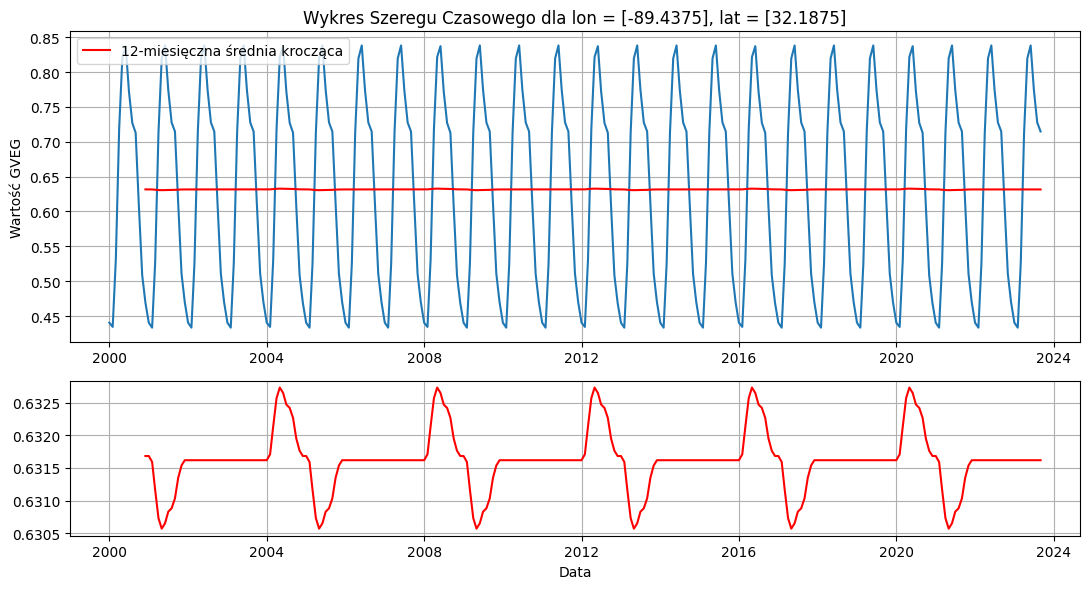

In [28]:
# Test
plot_time_series(GVEG_time_series, 'GVEG')

In [29]:
# losujemy 10 par wspołrzednych ze zbioru nasa
random = distinct_wsp.sample(10, random_state=123)

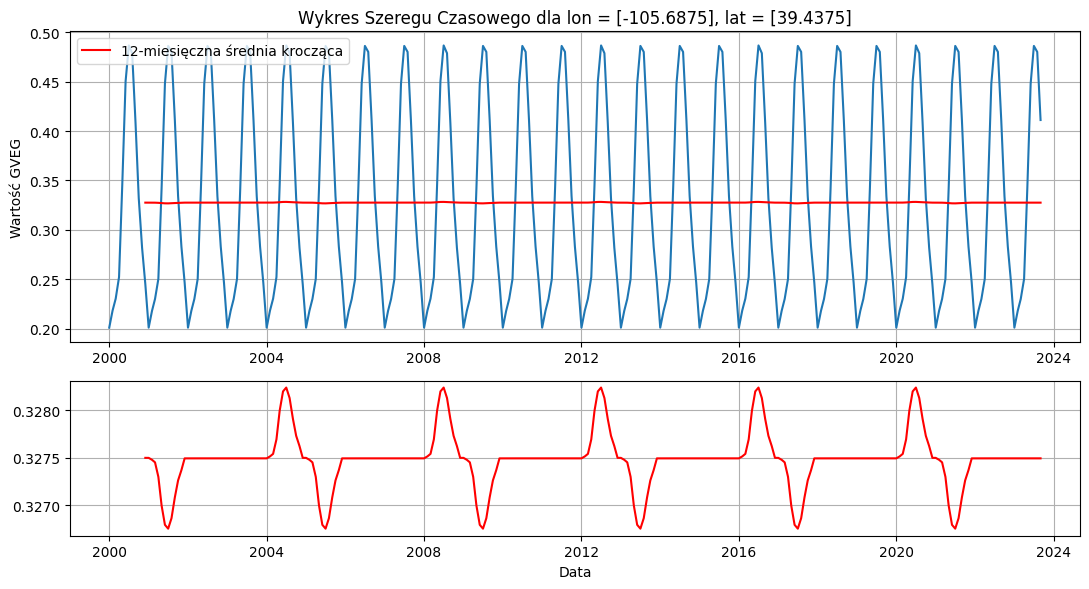

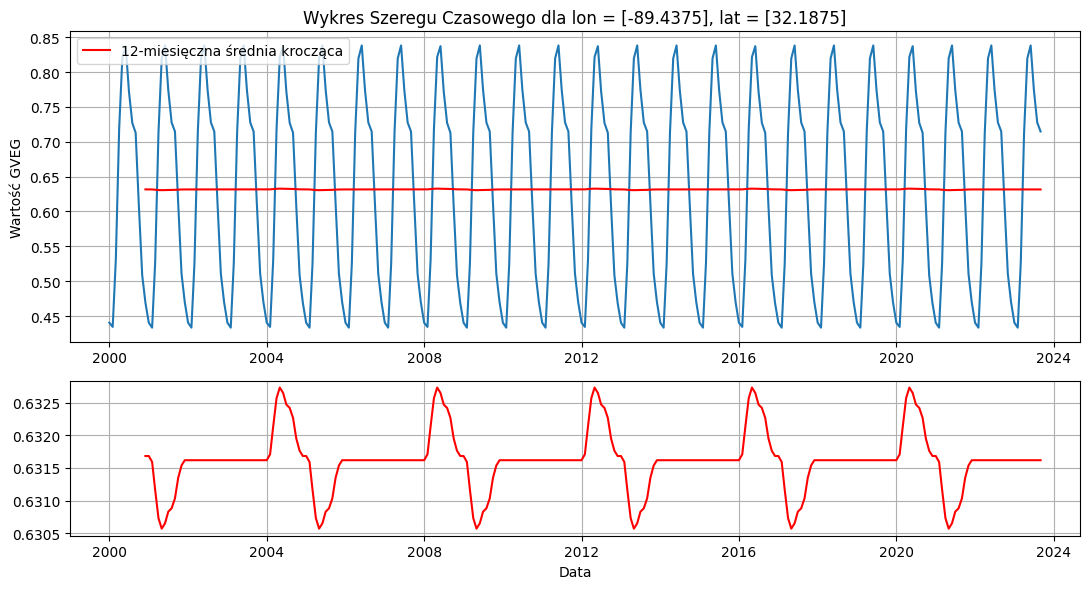

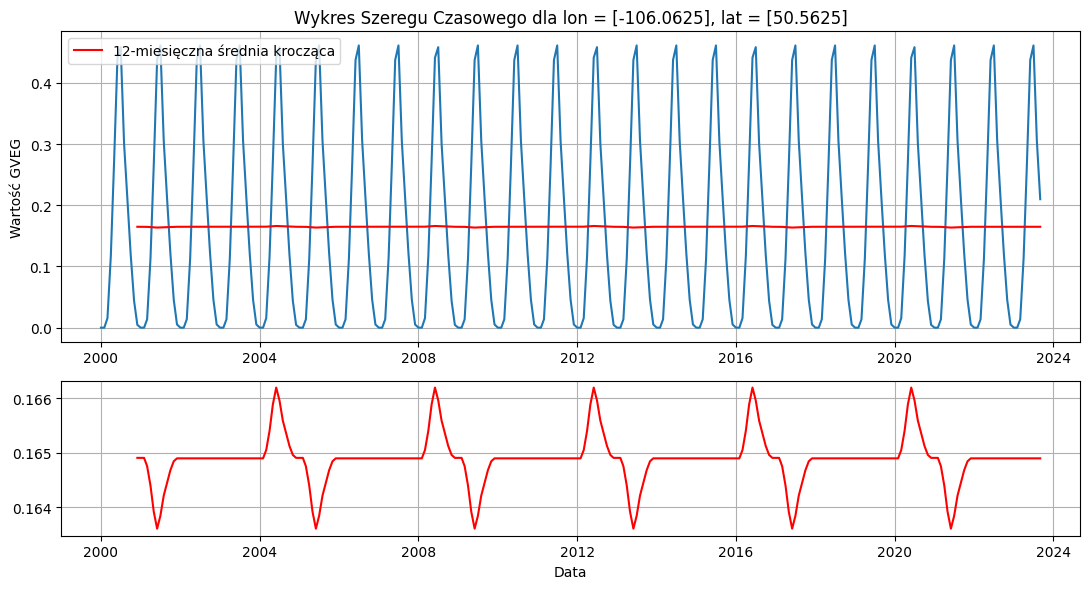

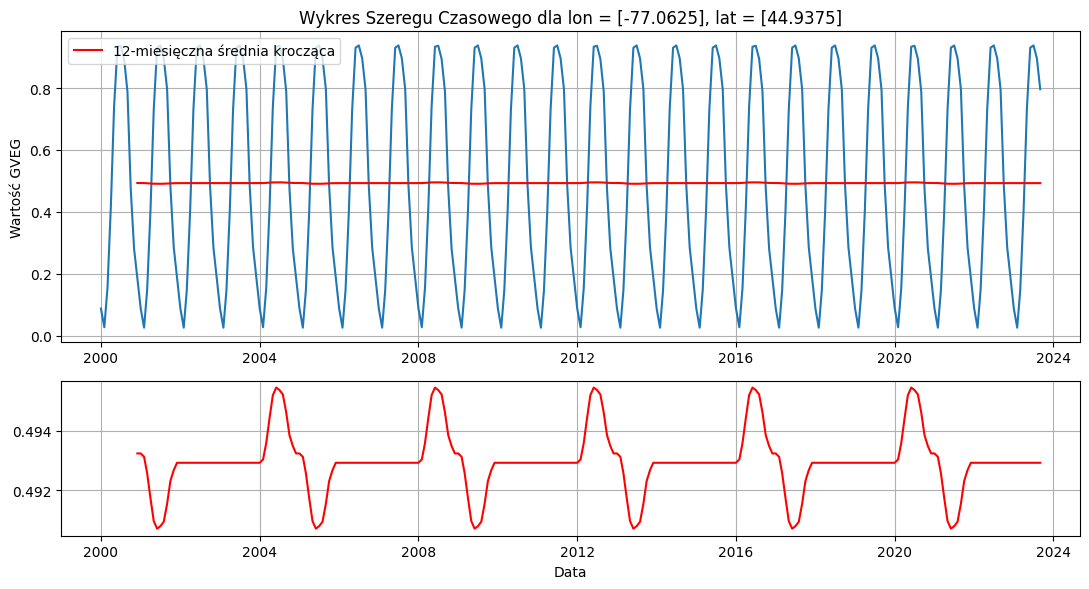

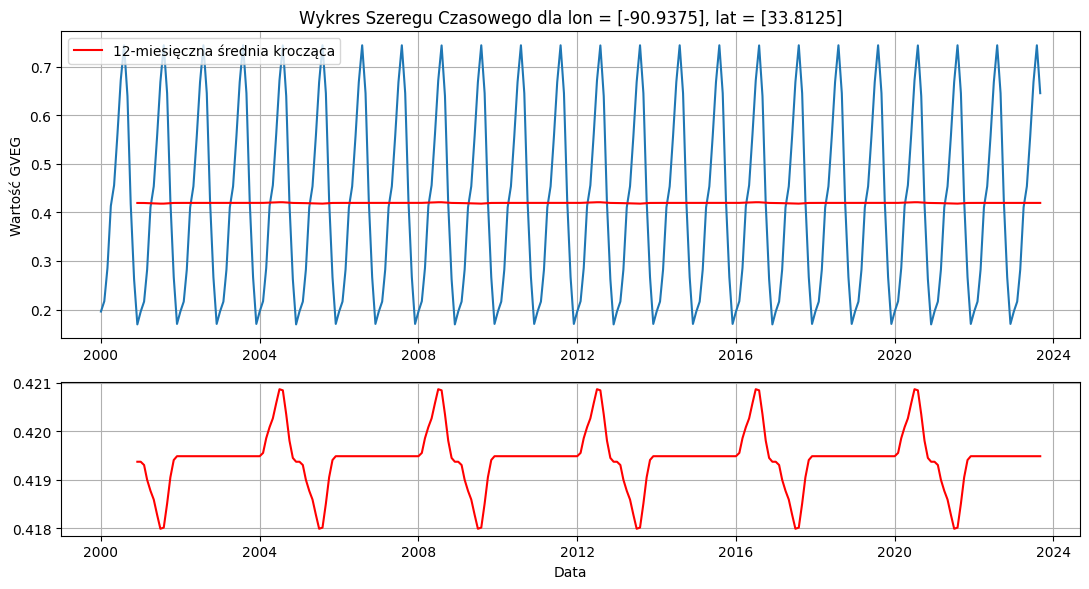

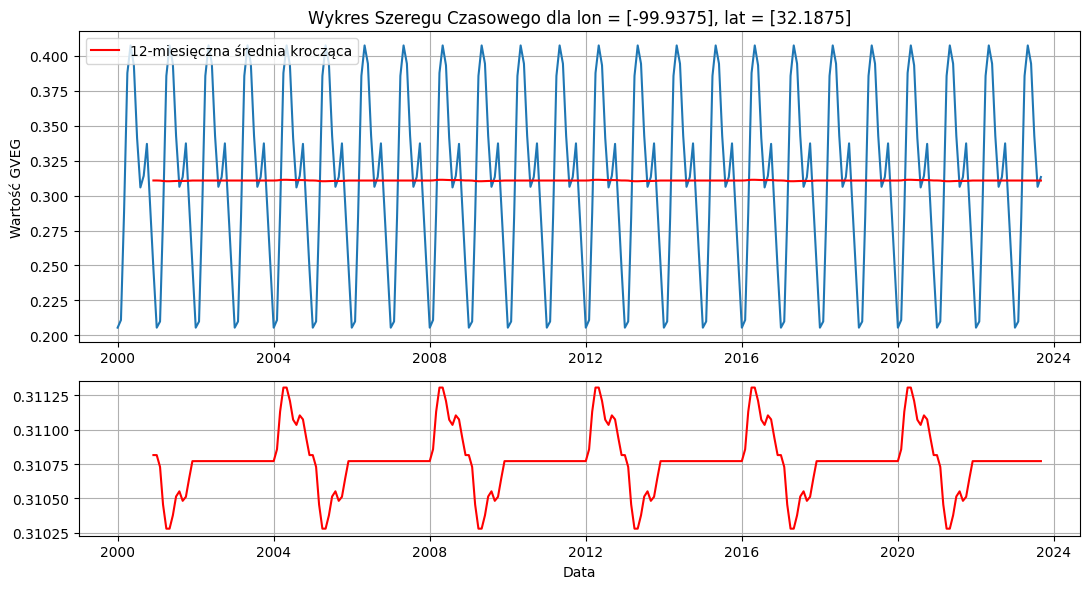

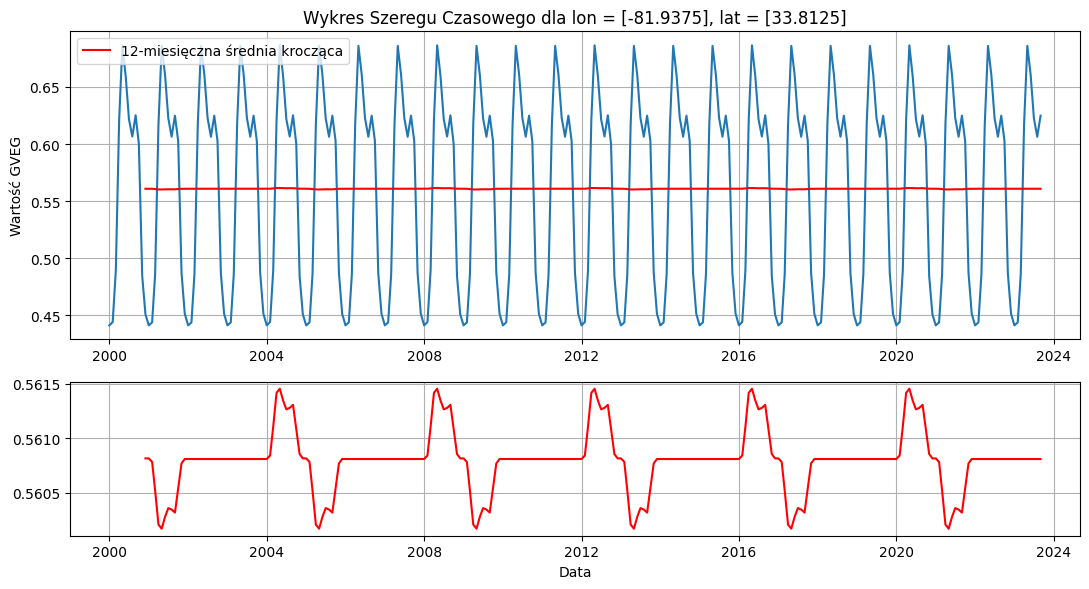

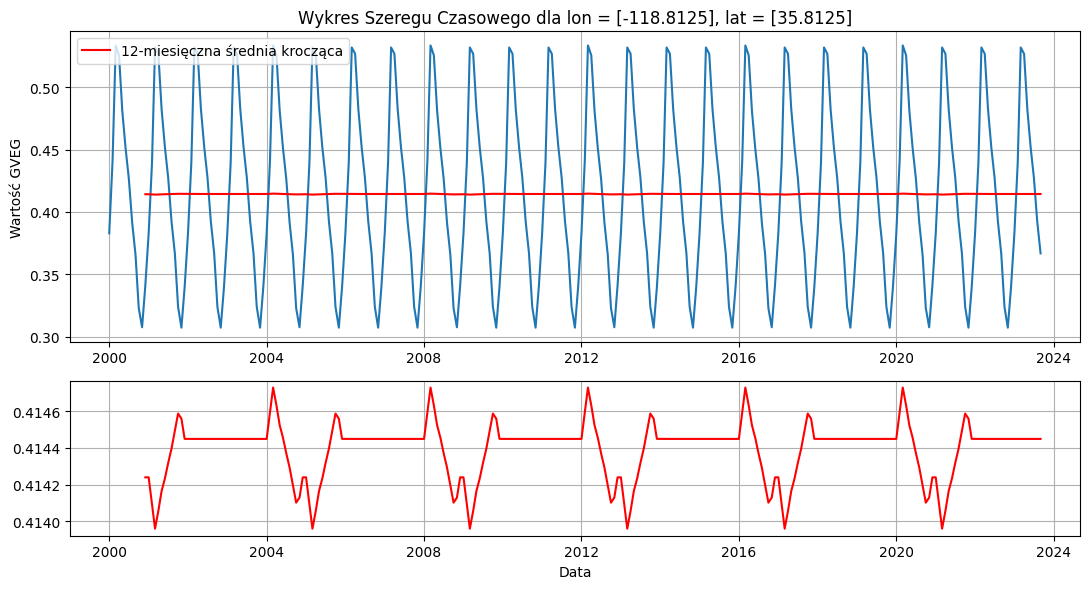

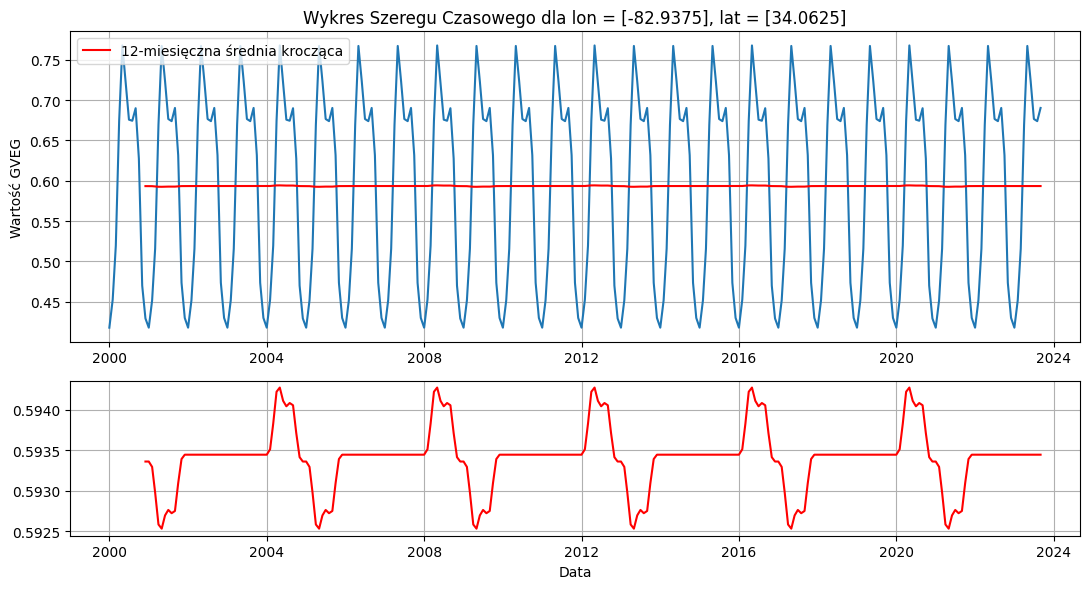

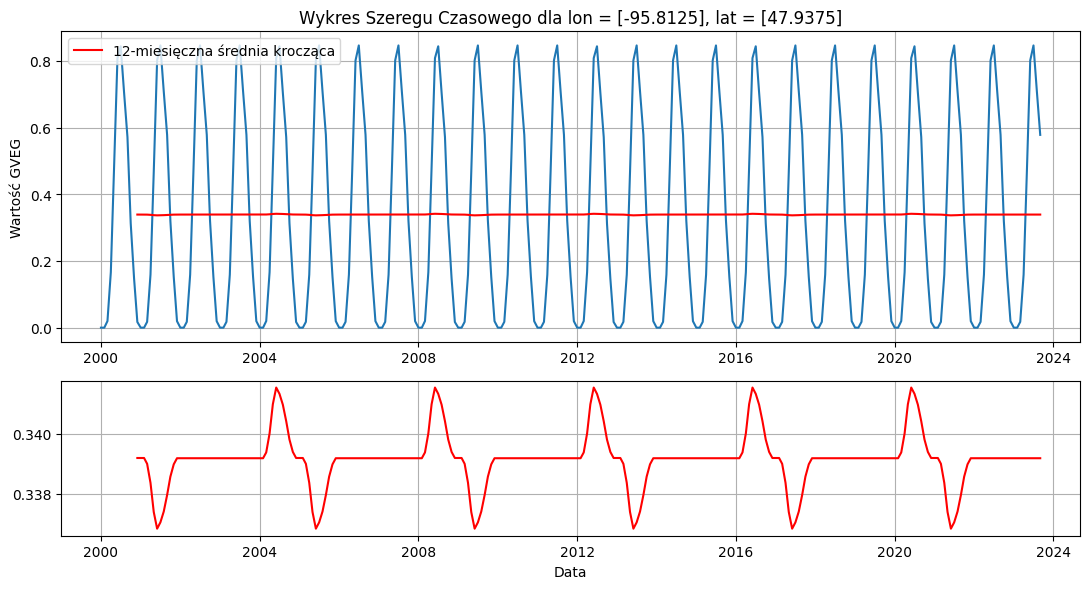

In [30]:
# sprawdzenie szeregu czasowego dla wylosowanych współrzędnych
for index, row in random.iterrows():
  GVEG_time_series = extract_time_series_from_dataframe(GVEG_SparkDataFrame, row['lon'], row['lat'])
  plot_time_series(GVEG_time_series, 'GVEG')

In [31]:
# pustynia mojave i jej "obrzeża" (ograniczenie terenu do współrzednych wytyczających skrajne krańce pustyni)
mojave = distinct_wsp[(distinct_wsp['lon'] >= -116.15) &  (distinct_wsp['lon']  <= -114.95) & (distinct_wsp['lat']  <= 35.45) & (distinct_wsp['lat']  >= 34.7)]

In [32]:
# losujemy 10 współrzednych z zakresu pustyni mojave i jej obrzeży
random_mojave = mojave.sample(10, random_state=123)

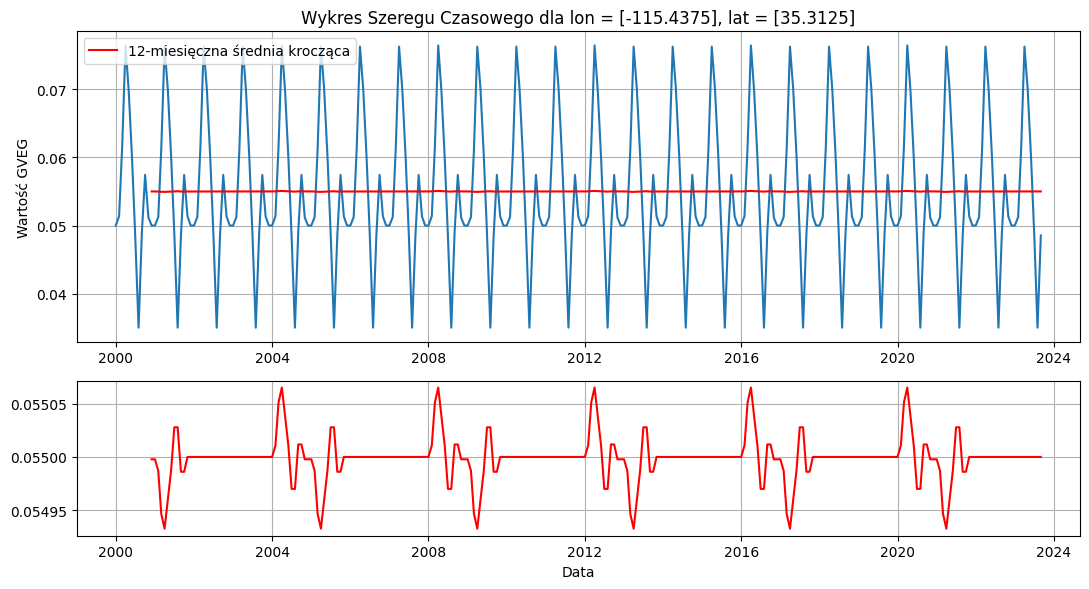

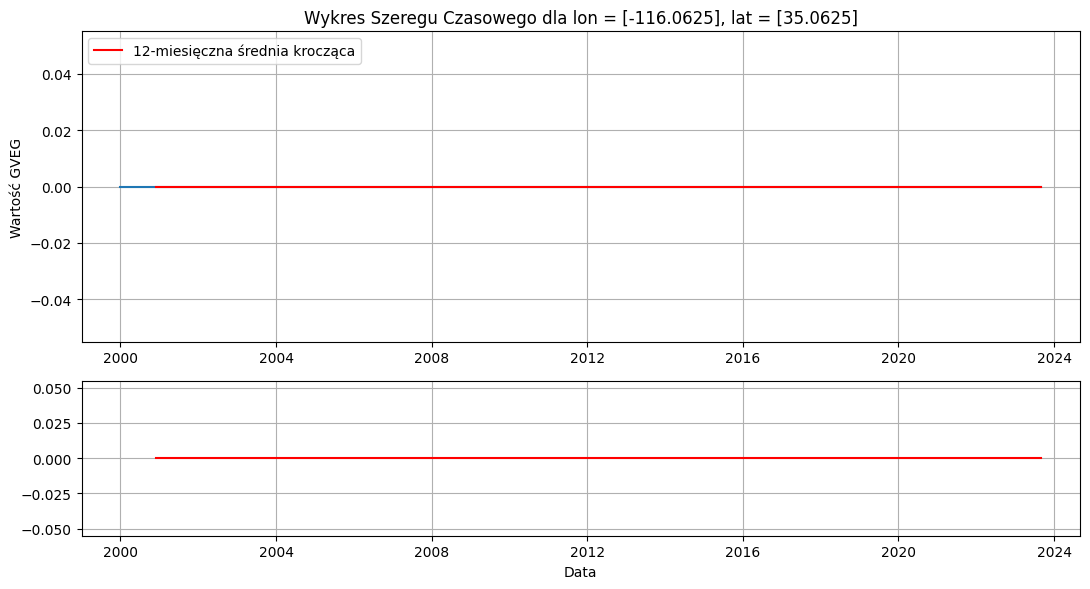

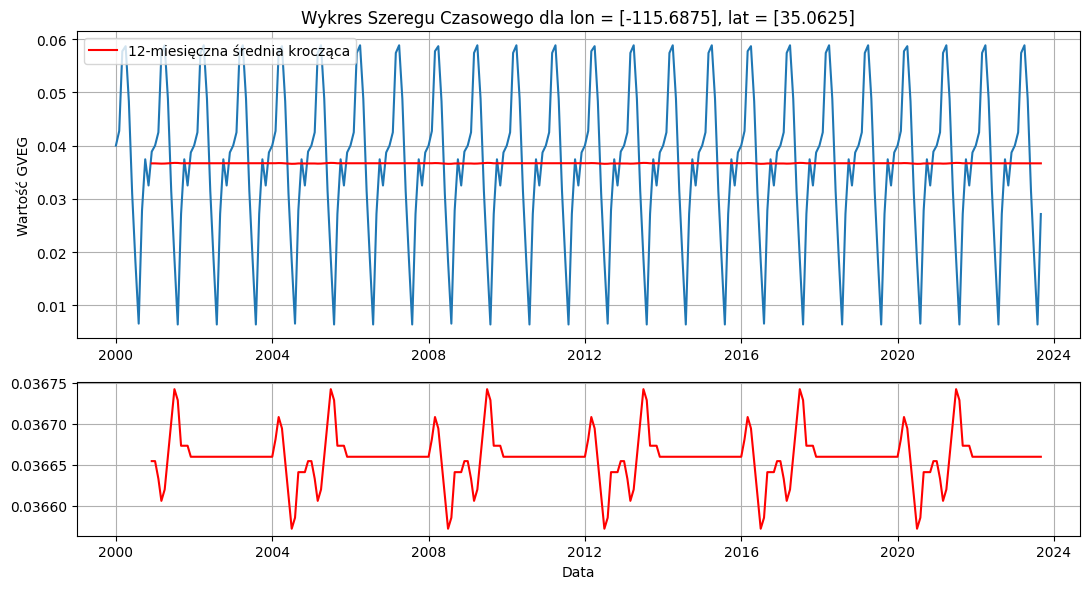

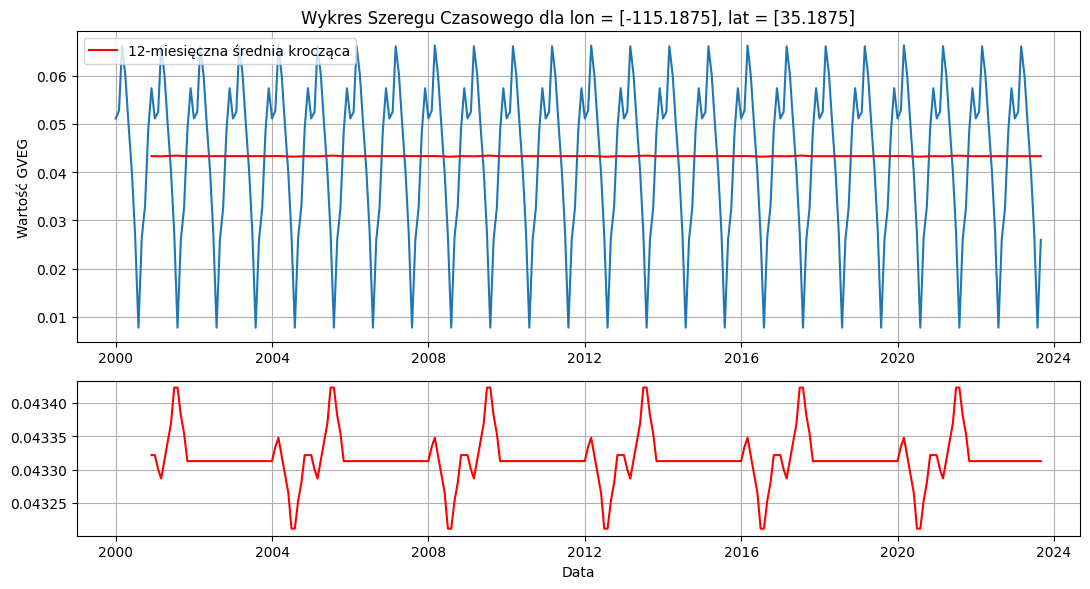

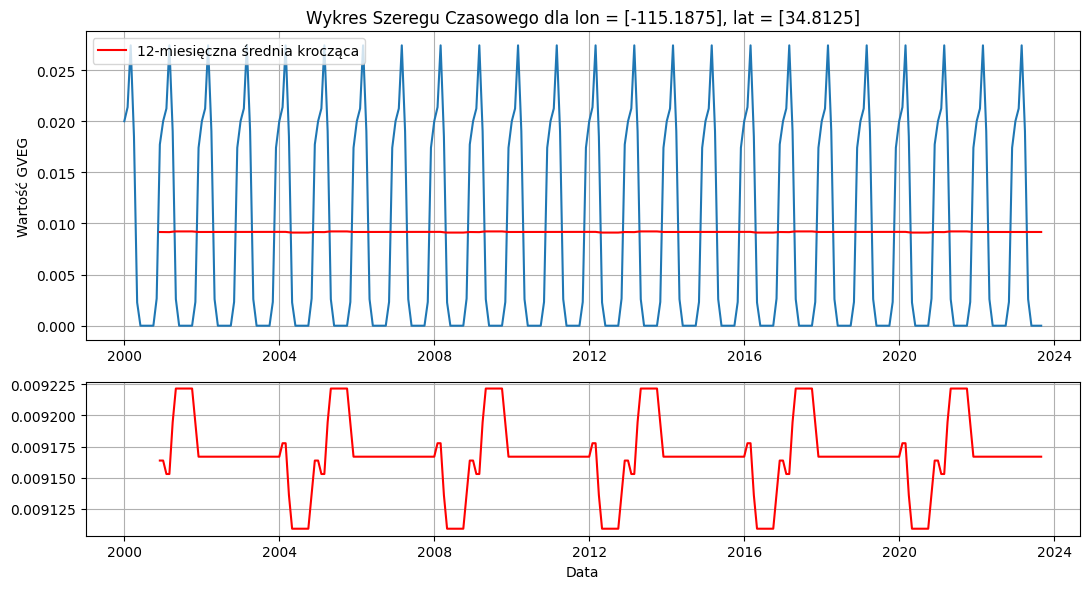

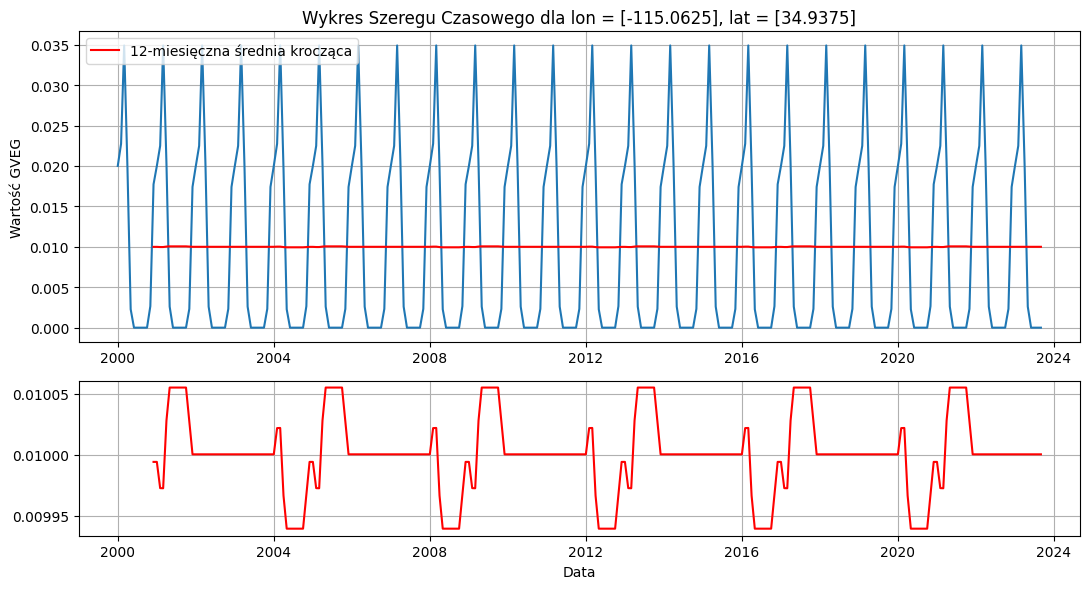

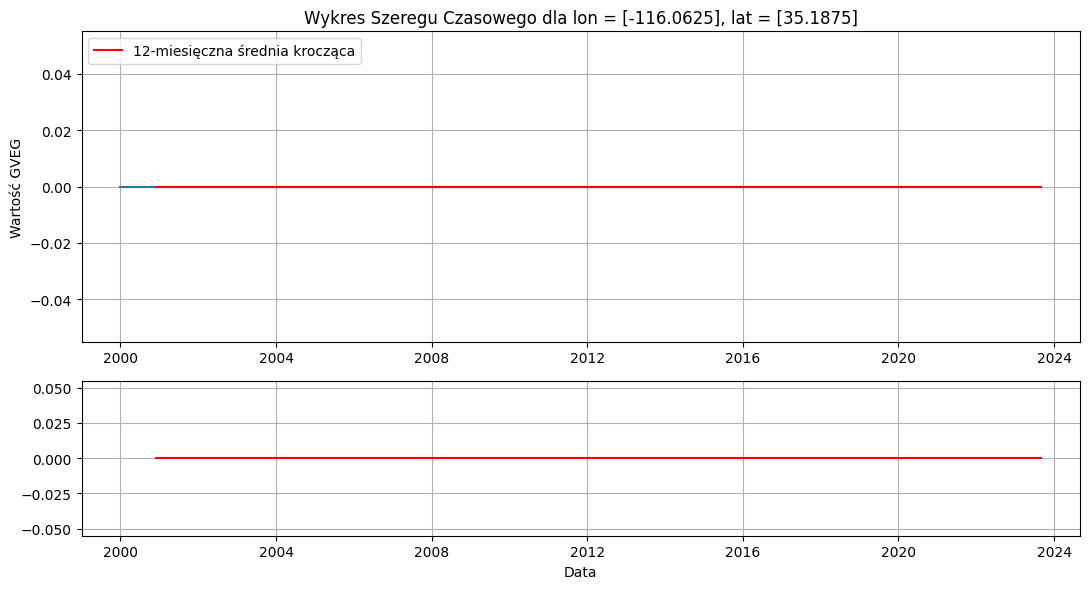

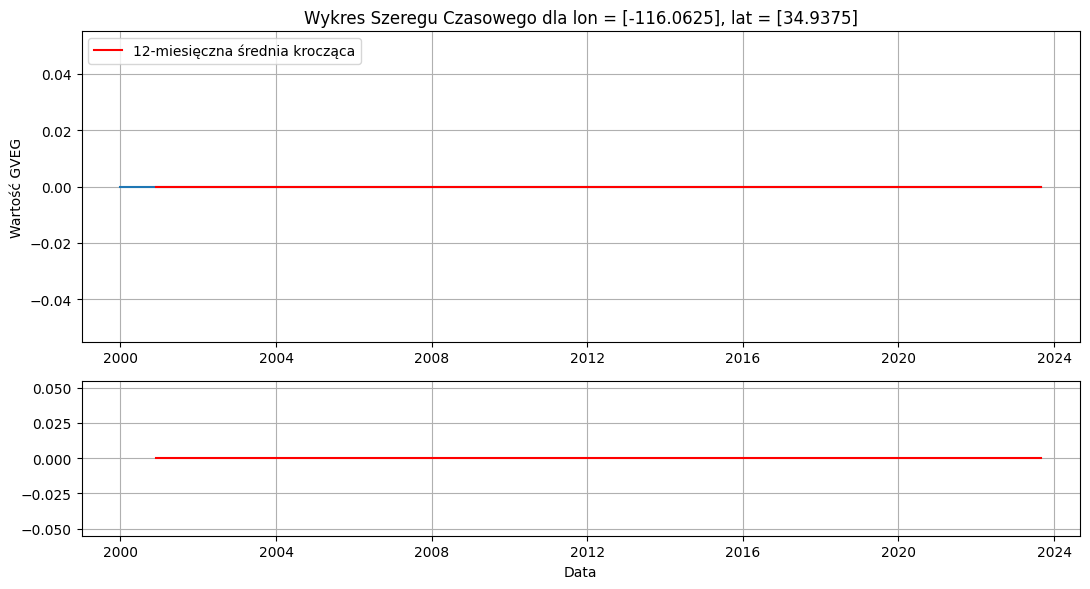

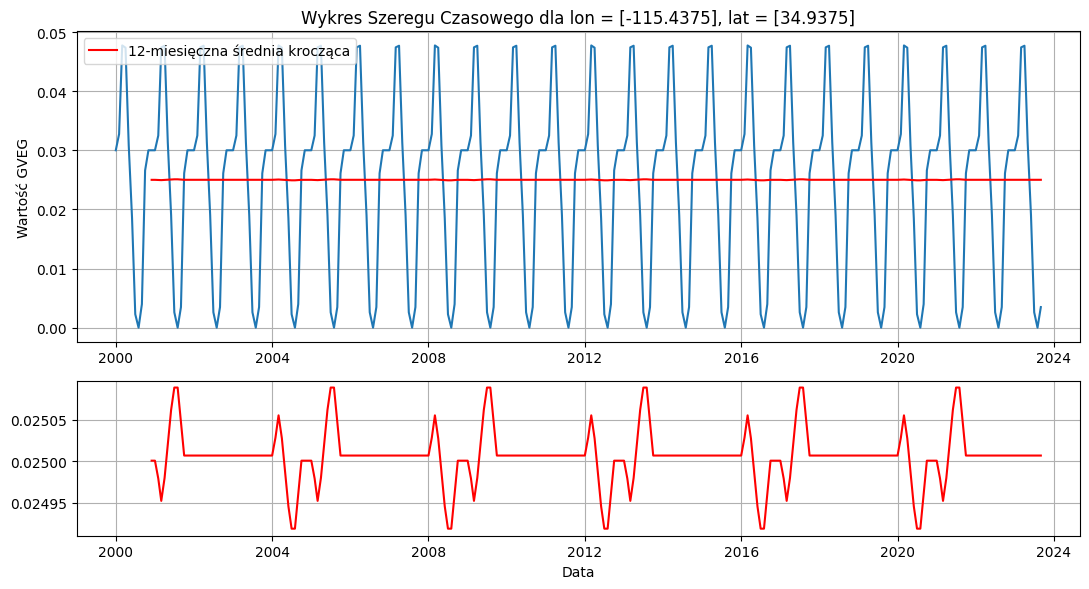

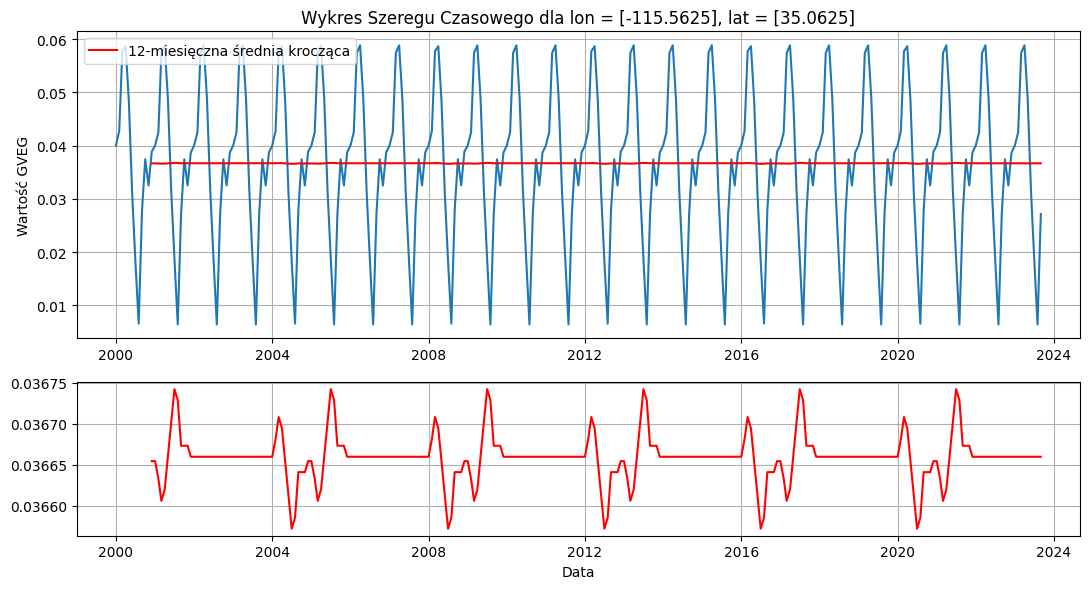

In [33]:
# sprawdzenie szeregu czasowego dla wylosowanych współrzędnych
for index, row in random_mojave.iterrows():
  GVEG_time_series = extract_time_series_from_dataframe(GVEG_SparkDataFrame, row['lon'], row['lat'])
  plot_time_series(GVEG_time_series, 'GVEG')